In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.decomposition import PCA
from adjustText import adjust_text
from sklearn.linear_model import LassoCV

In [2]:
df = pd.read_csv('winequality-red.csv', sep=';')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


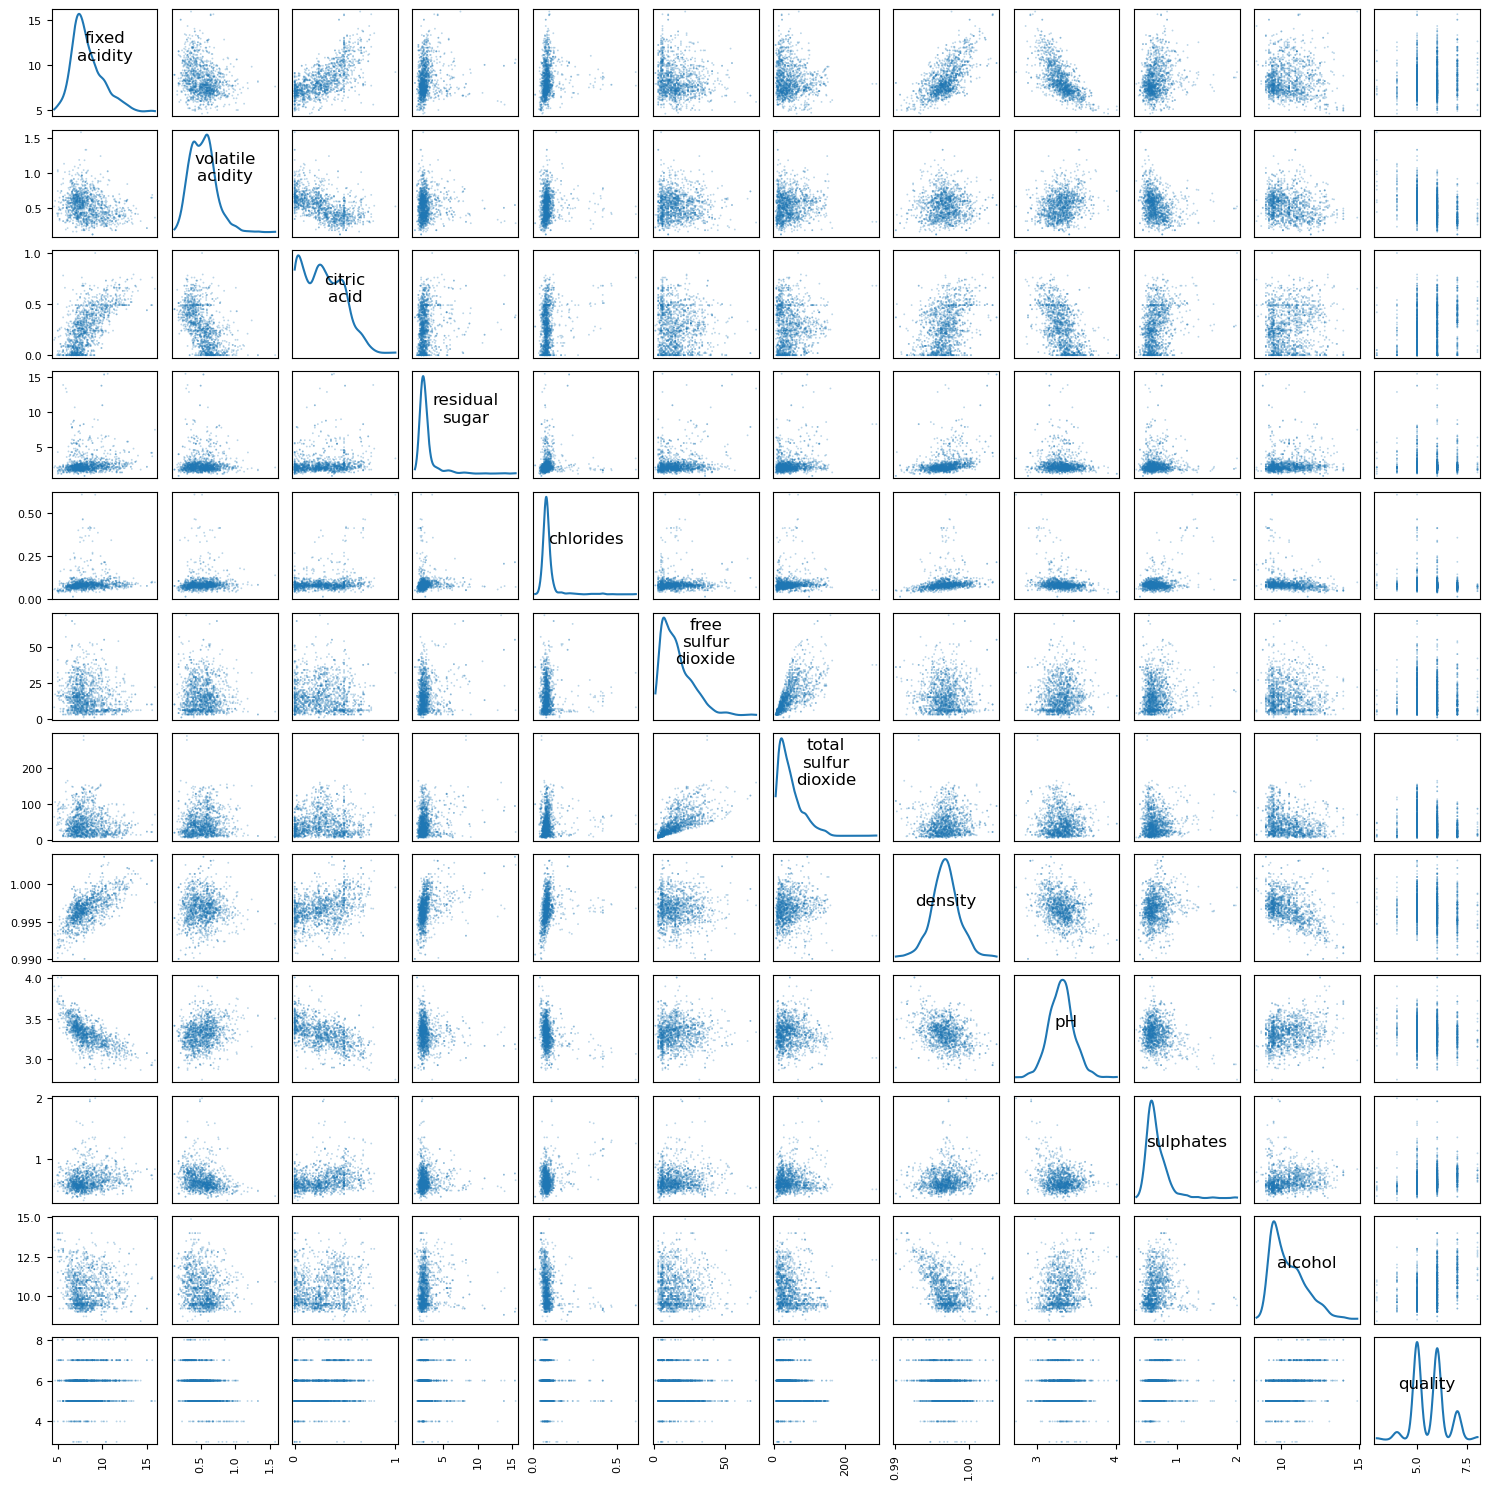

In [4]:
axes = pd.plotting.scatter_matrix(df, alpha=0.3, s=7, figsize=(15, 15), diagonal='kde')
plot_labels = [label.replace(' ', '\n') for label in df.columns]

for i, ax in enumerate(axes.flatten()):
    ax.yaxis.label.set_ha('right')
    if i % (len(df.columns) + 1) == 0:
        ax.text(0.5, 0.5, plot_labels[i // len(df.columns)], horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout(h_pad=0.4, w_pad=0.4)
plt.show()

In [5]:
y = df['quality']
X = df.drop(['quality'], axis=1)

In [6]:
X_scaled = (X - X.mean()) / X.std()
X_scaled = sm.add_constant(X_scaled)
model = sm.OLS(y, X_scaled).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Date:                Sun, 09 Jun 2024   Prob (F-statistic):          1.79e-145
Time:                        23:41:24   Log-Likelihood:                -1569.1
No. Observations:                1599   AIC:                             3162.
Df Residuals:                    1587   BIC:                             3227.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6360 

In [7]:
def stepwise_selection_p(X, y, significance_level=0.05):
    """
    Perform stepwise variable selection by starting with all features and 
    iteratively removing the feature with the highest p-value.

    Parameters:
    X (pd.DataFrame): Explanatory variables
    y (pd.Series): Dependent variable
    significance_level (float): Significance level for hypothesis testing

    Returns:
    selected_features (list): List of selected features
    """
    selected_features = X.columns.tolist()

    while len(selected_features) > 0:
        X_const = sm.add_constant(X[selected_features])
        model = sm.OLS(y, X_const).fit()
        p_values = model.pvalues[1:]  # exclude the constant
        max_p_value = p_values.max()

        if max_p_value > significance_level:
            feature_with_p_max = p_values.idxmax()
            selected_features.remove(feature_with_p_max)
        else:
            break

    return selected_features

In [8]:
selected_features = stepwise_selection_p(X, y)
selected_features

['volatile acidity',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'pH',
 'sulphates',
 'alcohol']

In [9]:
X_selected = X[selected_features]
X_selected_scaled = (X_selected - X_selected.mean()) / X_selected.std()
X_selected_scaled = sm.add_constant(X_selected_scaled)
model_selected = sm.OLS(y, X_selected_scaled).fit()
print(model_selected.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     127.6
Date:                Sun, 09 Jun 2024   Prob (F-statistic):          5.32e-149
Time:                        23:41:24   Log-Likelihood:                -1570.5
No. Observations:                1599   AIC:                             3157.
Df Residuals:                    1591   BIC:                             3200.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6360 

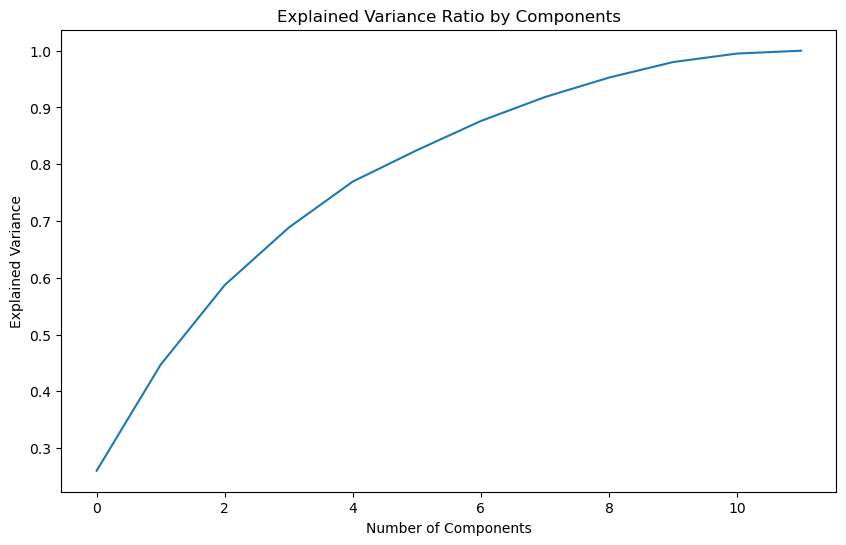

In [10]:
pca = PCA()
data = (df - df.mean()) / df.std()
data_pca = pca.fit_transform(data)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance Ratio by Components')
plt.show()

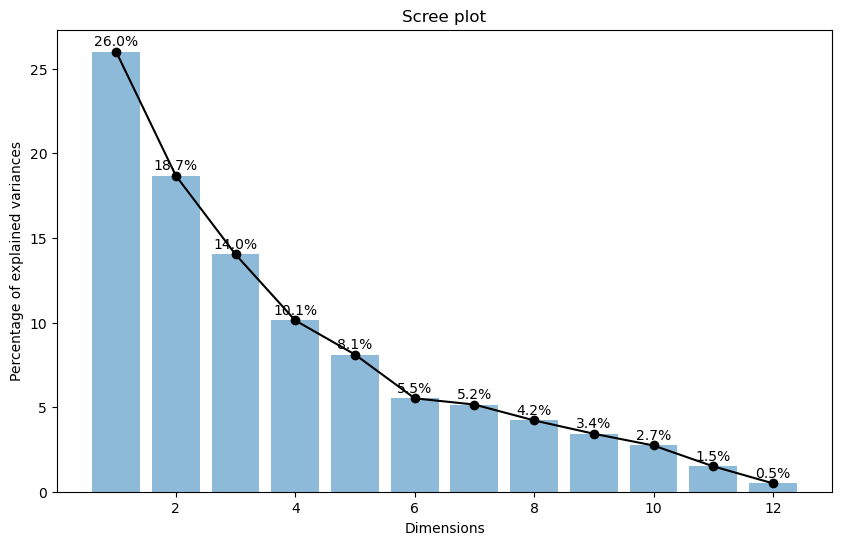

In [11]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_ * 100, alpha=0.5, align='center')
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_ * 100, marker='o', color='black')

plt.xlabel('Dimensions')
plt.ylabel('Percentage of explained variances')
plt.title('Scree plot')

for i, v in enumerate(pca.explained_variance_ratio_):
    plt.text(i + 1, v * 100 + 1, f"{v * 100:.1f}%", ha='center', va='top')

plt.show()

In [12]:
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

eig_val_df = pd.DataFrame({
    'Eigenvalue': explained_variance,
    'Variance percent': explained_variance_ratio * 100,
    'Cumulative variance percent': cumulative_variance_ratio * 100
})

print(eig_val_df)

    Eigenvalue  Variance percent  Cumulative variance percent
0     3.121168         26.009731                    26.009731
1     2.241882         18.682350                    44.692081
2     1.682920         14.024331                    58.716412
3     1.215021         10.125174                    68.841586
4     0.973264          8.110530                    76.952116
5     0.662592          5.521602                    82.473718
6     0.618318          5.152648                    87.626366
7     0.505873          4.215605                    91.841971
8     0.411308          3.427563                    95.269534
9     0.327919          2.732662                    98.002195
10    0.180219          1.501822                    99.504017
11    0.059518          0.495983                   100.000000


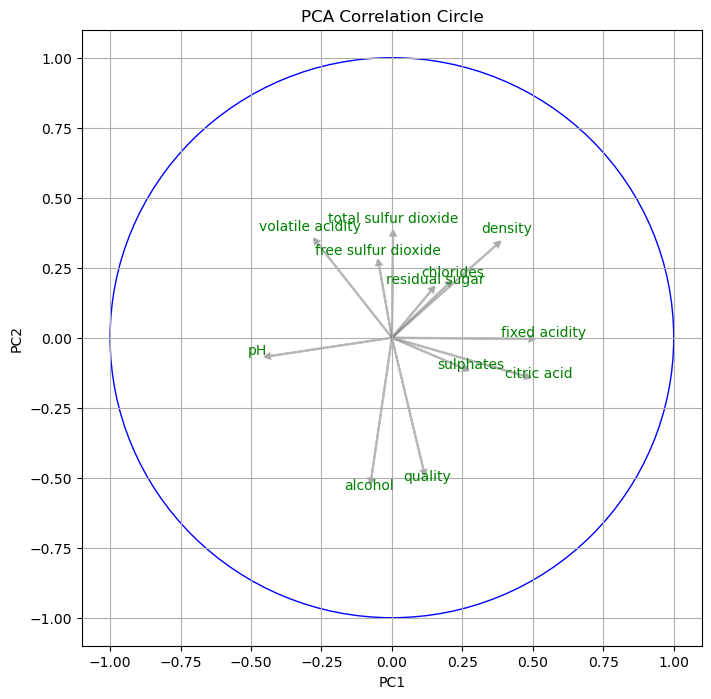

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)

circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b')
ax.add_artist(circle)

for i in range(pca.components_.shape[1]):
    ax.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
             head_width=0.02, head_length=0.02, linewidth=1.5, color='gray', alpha=0.5)
    ax.text(pca.components_[0, i] * 1.1, pca.components_[1, i] * 1.1, df.columns[i],
            color='g', ha='center', va='bottom', fontsize=10)

ax.grid()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Correlation Circle')
plt.show()

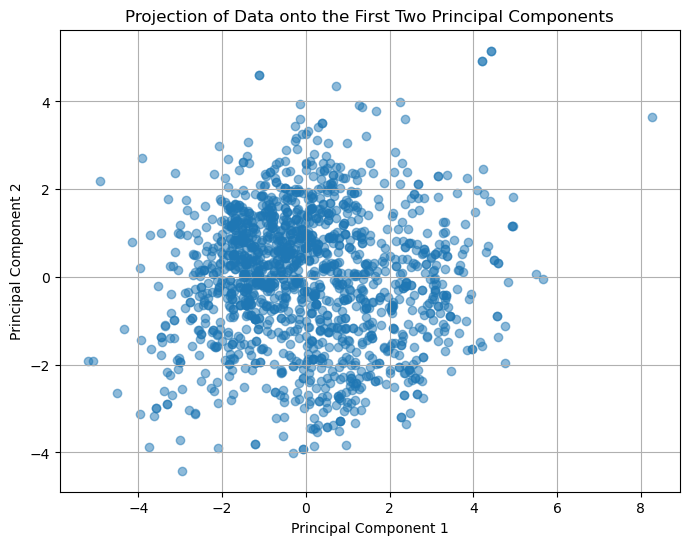

In [14]:
principal_df = pd.DataFrame(data=data_pca[:, :2], columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
plt.scatter(principal_df['PC1'], principal_df['PC2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Projection of Data onto the First Two Principal Components')
plt.grid()
plt.show()

In [15]:
lasso = LassoCV(cv=10)
y = df['quality']
X = df.drop(['quality'], axis=1)
X = (X - X.mean()) / X.std()
lasso.fit(X, y)
print(lasso.coef_)
print(X.columns[lasso.coef_ == 0])

[ 0.         -0.18391447 -0.          0.         -0.07610444  0.0178889
 -0.07997849 -0.         -0.05481267  0.13570471  0.3029159 ]
Index(['fixed acidity', 'citric acid', 'residual sugar', 'density'], dtype='object')


Text(0.5, 1.0, 'Lasso Coefficients')

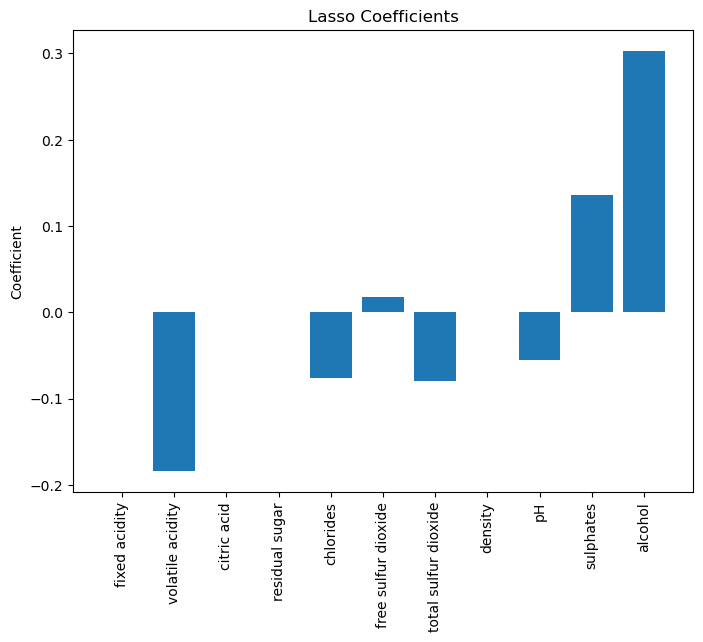

In [16]:
plt.figure(figsize=(8, 6))
plt.bar(X.columns, lasso.coef_)
plt.xticks(rotation=90)
plt.ylabel('Coefficient')
plt.title('Lasso Coefficients')
